In [14]:
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from statsmodels.tsa.arima.model import ARIMA
from nbeats_pytorch.model import NBeatsNet

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../..')

In [15]:
################################################################################
# Data preparation stage
################################################################################

TIME_STEP = 5

from utils.train import *

train_df, val_df, test_df = load_service_workload()


In [16]:
train_grouped_df = train_df.groupby('msinstanceid')
val_grouped_df = val_df.groupby('msinstanceid')
test_grouped_df = test_df.groupby('msinstanceid')

train_http_rt_df = train_grouped_df.apply(lambda x: split_array_by_step(x, TIME_STEP + 1))
val_http_rt_df = val_grouped_df.apply(lambda x: split_array_by_step(x, TIME_STEP + 1))
test_http_rt_df = test_grouped_df.apply(lambda x: split_array_by_step(x, TIME_STEP + 1))


In [17]:
train_http_rt_df[0][0]

,HTTP_RT,Polyfit_HTTP_RT,Mean_HTTP_RT,Median_HTTP_RT
243119,0.198647,0.528530,0.048184,0.098364
243120,0.201250,0.556573,0.093325,0.105751
243121,0.197626,0.543184,0.090176,0.099336
243122,0.189729,0.534453,0.095913,0.115082
243123,0.182550,0.526646,0.099062,0.133329
243124,0.179805,0.506357,0.089842,0.133329


In [18]:

train_workload = np.concatenate(train_http_rt_df, axis=0)
val_workload = np.concatenate(val_http_rt_df, axis=0)
test_workload = np.concatenate(test_http_rt_df, axis=0)

In [19]:
train_workload.shape

(2127, 6, 4)

In [20]:
x_train, y_train = create_sequences(train_workload, TIME_STEP)
x_val, y_val = create_sequences(val_workload, TIME_STEP)
x_test, y_test = create_sequences(test_workload, TIME_STEP)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
################################################################################
# N-Beats
################################################################################

from N_Beats.N_Beats import NBeatsModel

n_beats_model = NBeatsModel.model(input_dim=TIME_STEP, output_dim=1, nb_blocks_per_stack=4, thetas_dim=4, hidden_size=32)
n_beats_model_trained, loss_array, val_loss_array = NBeatsModel.train(x_train[:, :, :1], y_train[:, :1], x_val[:, :, :1], y_val[:, :1], n_beats_model, 80, batch_size=16, device=device)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947713363776
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947713363776
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947713363776
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947713363776
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947835296736
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947835296736
     | -- GenericBlock(units=32, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139947835296736
     

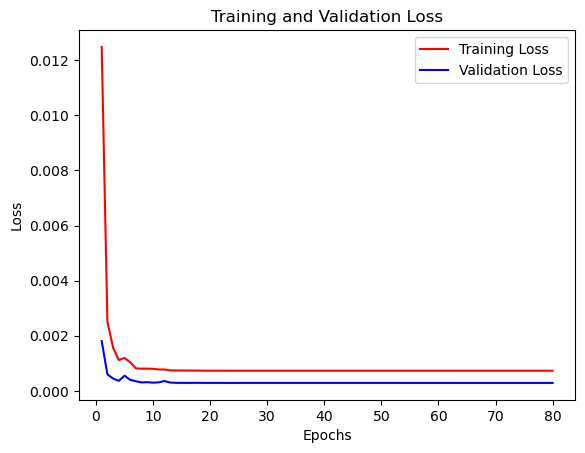

In [33]:
es = range(1, len(loss_array) + 1)

plt.plot(es, loss_array, 'r', label='Training Loss')
plt.plot(es, val_loss_array, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [24]:
################################################################################
# LSTM Model
#################################################################################

sys.path.append('../..')

from LSTM.LSTM import LSTMModel

################################################################################
# LSTM Model
#################################################################################
lstm_model = LSTMModel(input_dim=4, output_dim=4, hidden_dim=64, num_layers=1).to(device)
lstm_model_trained, loss_array, val_loss_array = train(x_train, y_train, x_val, y_val, lstm_model, 50, batch_size=32, device=device)


Epoch 1/50, Loss: 0.058006
Validation Loss: 0.016118
Epoch 2/50, Loss: 0.014203
Validation Loss: 0.010524
Epoch 3/50, Loss: 0.011270
Validation Loss: 0.009668
Epoch 4/50, Loss: 0.009896
Validation Loss: 0.009031
Epoch 5/50, Loss: 0.008553
Validation Loss: 0.009070
Epoch 6/50, Loss: 0.007490
Validation Loss: 0.007830
Epoch 7/50, Loss: 0.006810
Validation Loss: 0.007505
Epoch 8/50, Loss: 0.006305
Validation Loss: 0.007149
Epoch 9/50, Loss: 0.005958
Validation Loss: 0.006644
Epoch 10/50, Loss: 0.005593
Validation Loss: 0.005479
Epoch 11/50, Loss: 0.005449
Validation Loss: 0.005887
Epoch 12/50, Loss: 0.005120
Validation Loss: 0.005947
Epoch 13/50, Loss: 0.004887
Validation Loss: 0.005221
Epoch 14/50, Loss: 0.004688
Validation Loss: 0.005427
Epoch 15/50, Loss: 0.004475
Validation Loss: 0.004965
Epoch 16/50, Loss: 0.004358
Validation Loss: 0.004948
Epoch 17/50, Loss: 0.004334
Validation Loss: 0.004944
Epoch 18/50, Loss: 0.004200
Validation Loss: 0.005318
Epoch 19/50, Loss: 0.004017
Validatio

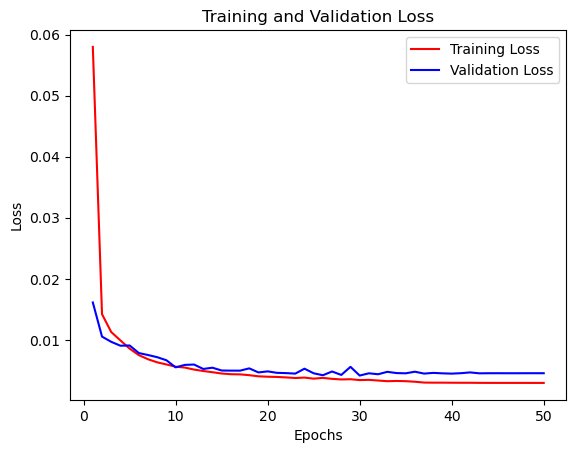

In [25]:
es = range(1, len(loss_array) + 1)

plt.plot(es, loss_array, 'r', label='Training Loss')
plt.plot(es, val_loss_array, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [26]:
################################################################################
# BI-LSTM Model
################################################################################
from Bi_LSTM.Bi_LSTM import BiLSTMModel

bi_lstm_model = BiLSTMModel(input_dim=4, output_dim=4, hidden_dim=16, num_layers=2).to(device)
bi_lstm_model_trained, loss_array, val_loss_array = train(x_train, y_train, x_val, y_val, bi_lstm_model, 50, batch_size=16, device=device)


Epoch 1/50, Loss: 0.050145
Validation Loss: 0.012431
Epoch 2/50, Loss: 0.011791
Validation Loss: 0.009557
Epoch 3/50, Loss: 0.009562
Validation Loss: 0.007928
Epoch 4/50, Loss: 0.007641
Validation Loss: 0.007147
Epoch 5/50, Loss: 0.006501
Validation Loss: 0.005834
Epoch 6/50, Loss: 0.005526
Validation Loss: 0.005261
Epoch 7/50, Loss: 0.005141
Validation Loss: 0.004590
Epoch 8/50, Loss: 0.004640
Validation Loss: 0.004458
Epoch 9/50, Loss: 0.004492
Validation Loss: 0.004243
Epoch 10/50, Loss: 0.004302
Validation Loss: 0.004193
Epoch 11/50, Loss: 0.004154
Validation Loss: 0.004668
Epoch 12/50, Loss: 0.004040
Validation Loss: 0.004414
Epoch 13/50, Loss: 0.003936
Validation Loss: 0.004570
Epoch 14/50, Loss: 0.003913
Validation Loss: 0.004181
Epoch 15/50, Loss: 0.003833
Validation Loss: 0.004254
Epoch 16/50, Loss: 0.003714
Validation Loss: 0.004583
Epoch 17/50, Loss: 0.003668
Validation Loss: 0.004301
Epoch 18/50, Loss: 0.003643
Validation Loss: 0.004483
Epoch 19/50, Loss: 0.003567
Validatio

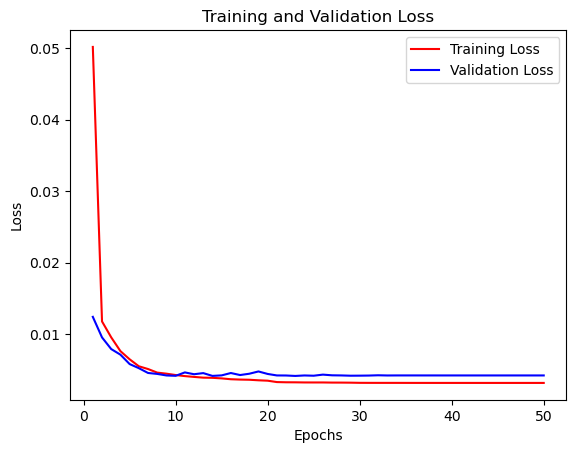

In [27]:
es = range(1, len(loss_array) + 1)

plt.plot(es, loss_array, 'r', label='Training Loss')
plt.plot(es, val_loss_array, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [30]:
################################################################################
# BI-LSTM Attention Model
################################################################################
from Bi_LSTM_Attention.BI_LSTM_Attention import BiLSTMAttentionModel

# Reshape the data to match the expected input format of nn.Conv1d
attention_x_train = np.transpose(x_train, (0, 2, 1))
attention_x_val = np.transpose(x_val, (0, 2, 1))
attention_x_test = np.transpose(x_test, (0, 2, 1))

attention_model = BiLSTMAttentionModel(input_dim=4, output_dim=4, seq_len=TIME_STEP, hidden_dim=64, num_layers=1).to(device)
attention_model_trained, loss_array, val_loss_array = train(attention_x_train, y_train, attention_x_val, y_val, attention_model, 70, batch_size=16, device=device)


Epoch 1/70, Loss: 0.034114
Validation Loss: 0.011053
Epoch 2/70, Loss: 0.009930
Validation Loss: 0.008032
Epoch 3/70, Loss: 0.007322
Validation Loss: 0.007644
Epoch 4/70, Loss: 0.006300
Validation Loss: 0.007103
Epoch 5/70, Loss: 0.005686
Validation Loss: 0.006657
Epoch 6/70, Loss: 0.005472
Validation Loss: 0.006164
Epoch 7/70, Loss: 0.005148
Validation Loss: 0.005580
Epoch 8/70, Loss: 0.005030
Validation Loss: 0.005709
Epoch 9/70, Loss: 0.004971
Validation Loss: 0.005634
Epoch 10/70, Loss: 0.004950
Validation Loss: 0.005502
Epoch 11/70, Loss: 0.004765
Validation Loss: 0.005369
Epoch 12/70, Loss: 0.004800
Validation Loss: 0.005159
Epoch 13/70, Loss: 0.004695
Validation Loss: 0.005214
Epoch 14/70, Loss: 0.004565
Validation Loss: 0.005936
Epoch 15/70, Loss: 0.004604
Validation Loss: 0.005646
Epoch 16/70, Loss: 0.004402
Validation Loss: 0.005256
Epoch 17/70, Loss: 0.004333
Validation Loss: 0.005209
Epoch 18/70, Loss: 0.004299
Validation Loss: 0.005346
Epoch 00018: reducing learning rate o

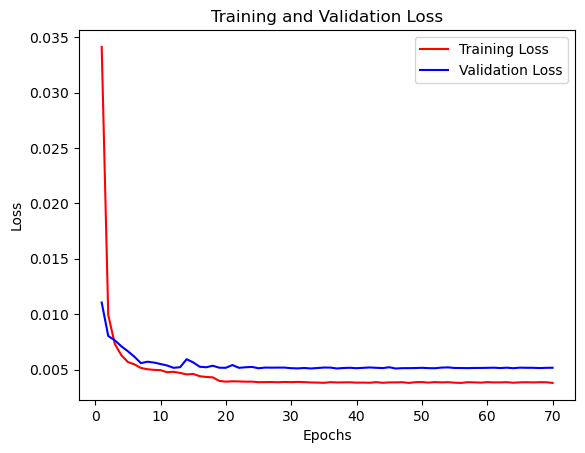

In [31]:
es = range(1, len(loss_array) + 1)

plt.plot(es, loss_array, 'r', label='Training Loss')
plt.plot(es, val_loss_array, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()